In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
LOCAL = False

if LOCAL:
    df = pd.read_csv('Final_df.csv')
    
else:
    df = pd.read_csv("/content/gdrive/My Drive/capstone project/modified datasets/Final_df.csv")


In [ ]:
df

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,Tweet_volume,Avg_score,Avg_score_norm,Tweet_volume_norm
0,0,2021-02-05,36931.546875,38225.906250,36658.761719,38144.308594,38144.308594,58598066402,1694.0,0.000025,0.043308,0.022462
1,1,2021-02-06,38138.386719,40846.546875,38138.386719,39266.011719,39266.011719,71326033653,3278.0,0.000021,0.032583,0.044547
2,2,2021-02-07,39250.191406,39621.835938,37446.152344,38903.441406,38903.441406,65500641143,3030.0,0.000009,0.000000,0.041089
3,3,2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,46196.464844,101467222687,5647.0,0.000055,0.129953,0.077577
4,4,2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,46481.105469,91809846886,4350.0,0.000057,0.136786,0.059494
...,...,...,...,...,...,...,...,...,...,...,...,...
431,431,2022-04-12,39533.714844,40617.585938,39388.328125,40127.183594,40127.183594,30991500854,NaN,NaN,NaN,NaN
432,432,2022-04-13,40123.570312,41430.054688,39712.746094,41166.730469,41166.730469,27691105228,18397.0,0.000058,0.137809,0.255347
433,433,2022-04-14,41160.218750,41451.480469,39695.746094,39935.515625,39935.515625,24342001973,27676.0,0.000063,0.153244,0.384722
434,434,2022-04-15,39939.402344,40617.722656,39866.832031,40553.464844,40553.464844,21756855753,40576.0,0.000075,0.185499,0.564583


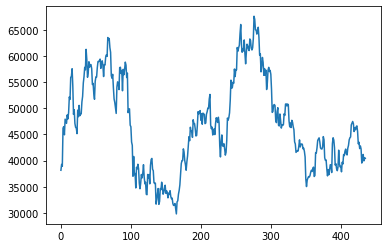

In [ ]:
df['Close'].plot()

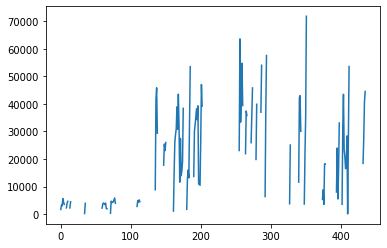

In [ ]:
df['Tweet_volume'].plot()

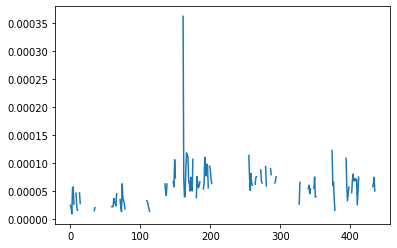

In [ ]:
df['Avg_score'].plot()

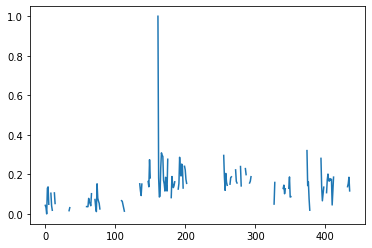

In [ ]:
df['Avg_score_norm'].plot()

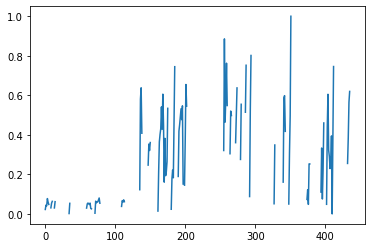

In [ ]:
df['Tweet_volume_norm'].plot()

In [ ]:
df.index=pd.to_datetime(df['Date'],format='%Y-%m-%d')

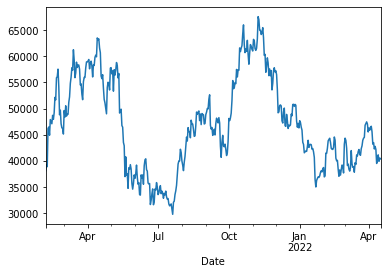

In [ ]:
df['Close'].plot()

In [ ]:
# interpolate missing values 

df.interpolate(method='time', inplace=True)

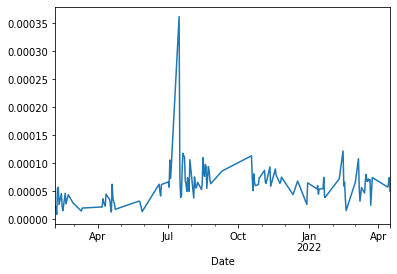

In [ ]:
df['Avg_score'].plot()

In [ ]:
train_df = df[:int(.7*len(df))]
test_df = df[int(.7*len(df)):]

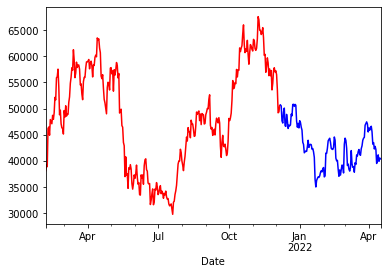

In [ ]:
train_df['Close'].plot(color='red')
test_df['Close'].plot(color='blue')

In [ ]:
#features & target for the model

features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Tweet_volume', 'Avg_score_norm']
target = ['Close']

In [ ]:
#features & target for the model
featureScaler = StandardScaler()
targetScaler = StandardScaler()

featureScaler.fit(train_df[features])
targetScaler.fit(train_df[target])

StandardScaler()

In [ ]:
featureScaler.mean_

array([4.87576764e+04, 5.01165990e+04, 4.72002390e+04, 4.87958098e+04,
       4.62037701e+10, 1.71516880e+04, 1.49834468e-01])

In [ ]:
def create_dataset(train, test, window_size=5):
    
    trainX = featureScaler.transform(train[features])
    trainY = targetScaler.transform(train[target])
    
    testX = featureScaler.transform(test[features])
    testY = targetScaler.transform(test[target])
    
    X_train = []
    Y_train  = []
    
    X_test = []
    Y_test = []
    
    
    for i in range(len(train)-window_size):
        X_train.append(trainX[i:i+window_size])
        Y_train.append(trainY[i+window_size])
        
    for  i in range(len(test)-window_size):
        X_test.append(testX[i:i+window_size])
        Y_test.append(testY[i+window_size])
        
    X_train = np.array(X_train)
    Y_train = np.array(Y_train)
    
    X_test = np.array(X_test)
    Y_test = np.array(Y_test)
    
    return (X_train, Y_train), (X_test, Y_test)    

In [ ]:
WINDOW_SIZE = 10

(X_train, Y_train), (X_test, Y_test) = create_dataset(train_df, test_df, WINDOW_SIZE)

In [ ]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)


(295, 10, 7) (295, 1)
(121, 10, 7) (121, 1)


In [ ]:
# Logistic Regression baseline model

regressor = LinearRegression()

In [ ]:
# for logistic regression, we will have to flatten the time dimension so that the data will be 2D (N, 10*7)
# so the model will have 70 inputs and 1 output

#train
regressor.fit(X_train.reshape(-1, 10*7), Y_train)

LinearRegression()

In [ ]:
#test
predictions = regressor.predict(X_test.reshape(-1, 10*7))

loss = mse(predictions, Y_test)

print(f'MSE for Logistic Regression Baseline : {loss}')


MSE for Logistic Regression Baseline : 0.03555573487455382


In [ ]:
pickle.dump(regressor, open('regressor.pkl', 'wb'))
pickle.dump(featureScaler, open('featureScaler.pkl', 'wb'))
pickle.dump(targetScaler, open('targetScaler.pkl', 'wb'))

In [ ]:
def plot_predictions(predictions):
    #inverse scale the predictions
    predictions = targetScaler.inverse_transform(predictions)
    predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    
    train_df['Close'].plot(color='red')
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')
    
def compare_pred(predictions):
    predictions = targetScaler.inverse_transform(predictions)
    predictions = pd.DataFrame([None]*WINDOW_SIZE + predictions.reshape(-1).tolist(), index=test_df.index)[0]
    test_df['Close'].plot(color='blue')
    predictions.plot(color='green')

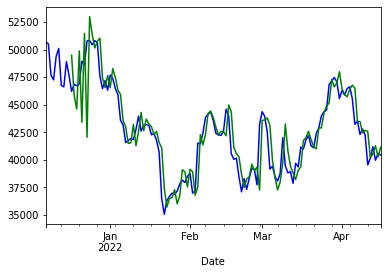

In [ ]:
compare_pred(predictions)

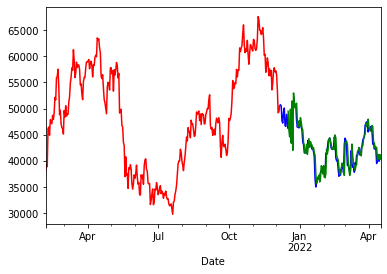

In [ ]:
plot_predictions(predictions)

In [ ]:
X_train.shape, Y_train.shape

((295, 10, 7), (295, 1))

In [ ]:
X_test.shape, Y_test.shape

((121, 10, 7), (121, 1))

In [ ]:
# recurrent model

recurrent = Sequential()
recurrent.add(InputLayer((10, 7)))
recurrent.add(GRU(64))
recurrent.add(Dense(32, 'relu'))
recurrent.add(Dense(1, 'linear'))
recurrent.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                14016     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
recurrent_c= ModelCheckpoint('recurrent/', save_best_only=True)
recurrent.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [ ]:
recurrent.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=40, callbacks=[recurrent_c])

Epoch 1/40
 7/10 [====================>.........] - ETA: 0s - loss: 0.5343 - root_mean_squared_error: 0.7310

10/10 [==============================] - 11s 933ms/step - loss: 0.4456 - root_mean_squared_error: 0.6676 - val_loss: 0.0841 - val_root_mean_squared_error: 0.2901
Epoch 2/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.1057 - root_mean_squared_error: 0.3252

10/10 [==============================] - 4s 480ms/step - loss: 0.1070 - root_mean_squared_error: 0.3271 - val_loss: 0.0730 - val_root_mean_squared_error: 0.2702
Epoch 3/40
 6/10 [=================>............] - ETA: 0s - loss: 0.0853 - root_mean_squared_error: 0.2921

10/10 [==============================] - 5s 524ms/step - loss: 0.0841 - root_mean_squared_error: 0.2900 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2337
Epoch 4/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0714 - root_mean_squared_error: 0.2672 - val_loss: 0.0626 - val_root_mean_squared_error: 0.2501
Epoch 5/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0624 - root_mean_squared_error: 0.2498

10/10 [==============================] - 4s 492ms/step - loss: 0.0624 - root_mean_squared_error: 0.2497 - val_loss: 0.0508 - val_root_mean_squared_error: 0.2254
Epoch 6/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0588 - root_mean_squared_error: 0.2425

10/10 [==============================] - 5s 520ms/step - loss: 0.0580 - root_mean_squared_error: 0.2407 - val_loss: 0.0504 - val_root_mean_squared_error: 0.2245
Epoch 7/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0552 - root_mean_squared_error: 0.2349 - val_loss: 0.0528 - val_root_mean_squared_error: 0.2298
Epoch 8/40
10/10 [==============================] - 0s 14ms/step - loss: 0.0540 - root_mean_squared_error: 0.2325 - val_loss: 0.0515 - val_root_mean_squared_error: 0.2268
Epoch 9/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0548 - root_mean_squared_error: 0.2342 - val_loss: 0.0521 - val_root_mean_squared_error: 0.2283
Epoch 10/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0537 - root_mean_squared_error: 0.2318

10/10 [==============================] - 4s 476ms/step - loss: 0.0509 - root_mean_squared_error: 0.2257 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2218
Epoch 11/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0475 - root_mean_squared_error: 0.2180

10/10 [==============================] - 4s 471ms/step - loss: 0.0498 - root_mean_squared_error: 0.2232 - val_loss: 0.0492 - val_root_mean_squared_error: 0.2218
Epoch 12/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0478 - root_mean_squared_error: 0.2186 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2301
Epoch 13/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0473 - root_mean_squared_error: 0.2175 - val_loss: 0.0547 - val_root_mean_squared_error: 0.2338
Epoch 14/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0462 - root_mean_squared_error: 0.2149 - val_loss: 0.0528 - val_root_mean_squared_error: 0.2297
Epoch 15/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0449 - root_mean_squared_error: 0.2119 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2240
Epoch 16/40
10/10 [==============================] - 0s 12ms/step - loss: 0.0442 - root_mean_squared_error: 0.2103 - val_loss: 0.0494 - val_root_mean_s

10/10 [==============================] - 5s 528ms/step - loss: 0.0436 - root_mean_squared_error: 0.2087 - val_loss: 0.0476 - val_root_mean_squared_error: 0.2182
Epoch 19/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0429 - root_mean_squared_error: 0.2072 - val_loss: 0.0511 - val_root_mean_squared_error: 0.2260
Epoch 20/40
 6/10 [=================>............] - ETA: 0s - loss: 0.0414 - root_mean_squared_error: 0.2034

10/10 [==============================] - 4s 475ms/step - loss: 0.0430 - root_mean_squared_error: 0.2074 - val_loss: 0.0464 - val_root_mean_squared_error: 0.2154
Epoch 21/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.0497 - val_root_mean_squared_error: 0.2229
Epoch 22/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0411 - root_mean_squared_error: 0.2027 - val_loss: 0.0500 - val_root_mean_squared_error: 0.2235
Epoch 23/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0405 - root_mean_squared_error: 0.2012 - val_loss: 0.0502 - val_root_mean_squared_error: 0.2241
Epoch 24/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0412 - root_mean_squared_error: 0.2030 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2171
Epoch 25/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0394 - root_mean_squared_error: 0.1984 - val_loss: 0.0500 - val_root_mean_s

10/10 [==============================] - 5s 529ms/step - loss: 0.0398 - root_mean_squared_error: 0.1995 - val_loss: 0.0461 - val_root_mean_squared_error: 0.2146
Epoch 27/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0396 - root_mean_squared_error: 0.1989

10/10 [==============================] - 4s 488ms/step - loss: 0.0393 - root_mean_squared_error: 0.1983 - val_loss: 0.0455 - val_root_mean_squared_error: 0.2133
Epoch 28/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0387 - root_mean_squared_error: 0.1967

10/10 [==============================] - 5s 526ms/step - loss: 0.0386 - root_mean_squared_error: 0.1964 - val_loss: 0.0442 - val_root_mean_squared_error: 0.2101
Epoch 29/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.1979

10/10 [==============================] - 4s 476ms/step - loss: 0.0380 - root_mean_squared_error: 0.1950 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2011
Epoch 30/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0385 - root_mean_squared_error: 0.1963

10/10 [==============================] - 5s 527ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.0401 - val_root_mean_squared_error: 0.2002
Epoch 31/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0401 - root_mean_squared_error: 0.2003 - val_loss: 0.0411 - val_root_mean_squared_error: 0.2028
Epoch 32/40
10/10 [==============================] - 0s 11ms/step - loss: 0.0379 - root_mean_squared_error: 0.1948 - val_loss: 0.0408 - val_root_mean_squared_error: 0.2020
Epoch 33/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0375 - root_mean_squared_error: 0.1937

10/10 [==============================] - 4s 483ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.0387 - val_root_mean_squared_error: 0.1966
Epoch 34/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0373 - root_mean_squared_error: 0.1931

10/10 [==============================] - 5s 532ms/step - loss: 0.0367 - root_mean_squared_error: 0.1916 - val_loss: 0.0370 - val_root_mean_squared_error: 0.1924
Epoch 35/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0355 - root_mean_squared_error: 0.1885 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1938
Epoch 36/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0359 - root_mean_squared_error: 0.1895 - val_loss: 0.0376 - val_root_mean_squared_error: 0.1938
Epoch 37/40
 9/10 [==========================>...] - ETA: 0s - loss: 0.0360 - root_mean_squared_error: 0.1897

10/10 [==============================] - 4s 473ms/step - loss: 0.0356 - root_mean_squared_error: 0.1886 - val_loss: 0.0367 - val_root_mean_squared_error: 0.1916
Epoch 38/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.1958

10/10 [==============================] - 5s 554ms/step - loss: 0.0371 - root_mean_squared_error: 0.1927 - val_loss: 0.0357 - val_root_mean_squared_error: 0.1889
Epoch 39/40
10/10 [==============================] - 0s 10ms/step - loss: 0.0369 - root_mean_squared_error: 0.1921 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1970
Epoch 40/40
 8/10 [=======================>......] - ETA: 0s - loss: 0.0381 - root_mean_squared_error: 0.1952

10/10 [==============================] - 5s 531ms/step - loss: 0.0362 - root_mean_squared_error: 0.1902 - val_loss: 0.0351 - val_root_mean_squared_error: 0.1873


In [ ]:
predictions = recurrent.predict(X_test)

4/4 [==============================] - 0s 4ms/step


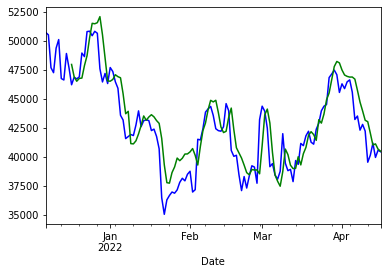

In [ ]:
compare_pred(predictions)

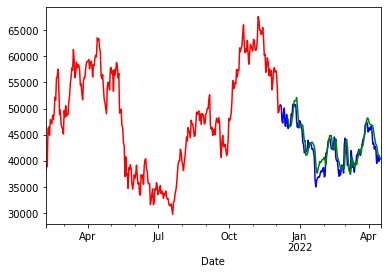

In [ ]:
plot_predictions(predictions)

In [ ]:
def calculate_r2(predictions, ground_truth):
    predictions = targetScaler.inverse_transform(predictions)
    score = r2_score(predictions, ground_truth)*100
    return score

In [ ]:
# calculate R2 metrics

regressor_predictions = regressor.predict(X_test.reshape(-1, 10*7))
recurrent_predictions = recurrent.predict(X_test)

regressor_r2 = calculate_r2(regressor_predictions, test_df['Close'][WINDOW_SIZE:])
recurrent_r2 = calculate_r2(recurrent_predictions, test_df['Close'][WINDOW_SIZE:])


print(f'R2 for Linear Regression model -> {regressor_r2:.2f}%')
print(f'R2 for GRU model -> {recurrent_r2:.2f}%')



4/4 [==============================] - 0s 4ms/step
R2 for Linear Regression model -> 76.14%
R2 for GRU model -> 73.04%
